In [2]:
## Import Libraries

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

### Data Loading

In [6]:
## Read the data into Dataframe
df = pd.read_excel("premiums_with_life_style.xlsx")
df.head()

,Age,Gender,Region,Marital_status,Physical_Activity,Stress_Level,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,56,Female,Southeast,Unmarried,Medium,Medium,2,Normal,No Smoking,Self-Employed,25L - 40L,37,High blood pressure,Gold,27944
1,38,Female,Northeast,Married,Low,High,5,Overweight,Occasional,Freelancer,10L - 25L,10,No Disease,Silver,21108
2,18,Female,Southwest,Unmarried,Medium,High,0,Normal,No Smoking,Freelancer,<10L,9,No Disease,Bronze,8459
3,55,Male,Northeast,Married,High,Medium,3,Overweight,Occasional,Salaried,<10L,9,Thyroid,Silver,21685
4,22,Male,Southeast,Unmarried,Medium,High,2,Normal,Regular,Self-Employed,10L - 25L,13,High blood pressure & Heart disease,Bronze,15984


In [7]:
df.shape

(10000, 15)

In [8]:
## format column names
df.columns = df.columns.str.replace(" ", "_").str.lower()
df.columns

Index(['age', 'gender', 'region', 'marital_status', 'physical_activity',
       'stress_level', 'number_of_dependants', 'bmi_category',
       'smoking_status', 'employment_status', 'income_level', 'income_lakhs',
       'medical_history', 'insurance_plan', 'annual_premium_amount'],
      dtype='object')

### Data Cleaning and EDA

In [10]:
## Check if null values in dataframe
df.isna().sum()

age                       0
gender                    0
region                    0
marital_status            0
physical_activity         0
stress_level              0
number_of_dependants      0
bmi_category              0
smoking_status            9
employment_status         7
income_level             18
income_lakhs              0
medical_history           0
insurance_plan            0
annual_premium_amount     0
dtype: int64

In [11]:
## remove rows with null data as there are very few null values out of huge dataset
df.dropna(inplace=True)
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
physical_activity        0
stress_level             0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

In [12]:
## check if any duplicate rows
df.duplicated().sum()

np.int64(0)

In [14]:
## no duplicates, but still removing duplicates
df.drop_duplicates(inplace=True)
df.duplicated().sum()

np.int64(0)

In [15]:
### statistics of numeric features in the dataframe
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,9973.000000,9973.000000,9973.000000,9973.000000
mean,41.319362,3.195628,23.382232,19503.816705
std,58.044687,21.679565,32.334811,8898.079736
min,18.000000,0.000000,1.000000,3582.000000
25%,24.000000,0.000000,6.000000,11774.000000
50%,37.000000,2.000000,16.000000,19314.000000
75%,50.000000,3.000000,31.000000,26500.000000
max,1178.000000,456.000000,960.000000,45854.000000


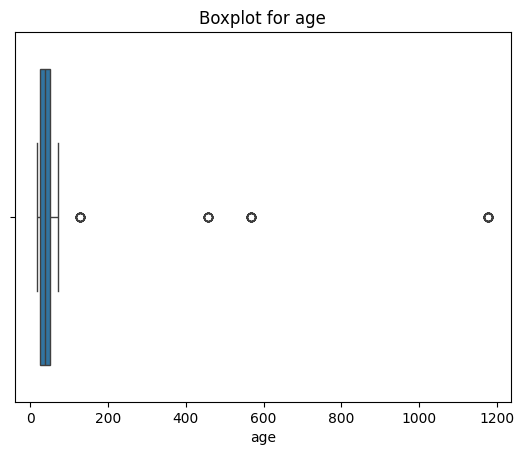

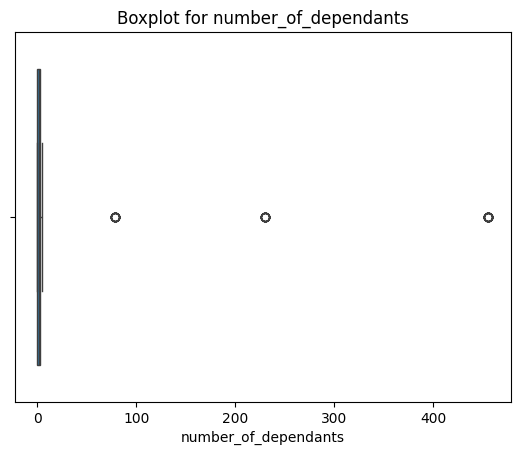

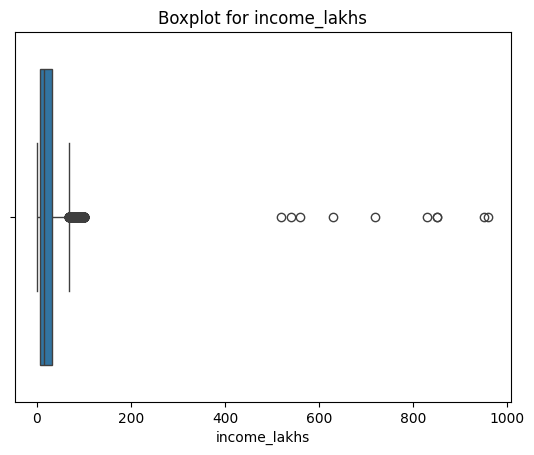

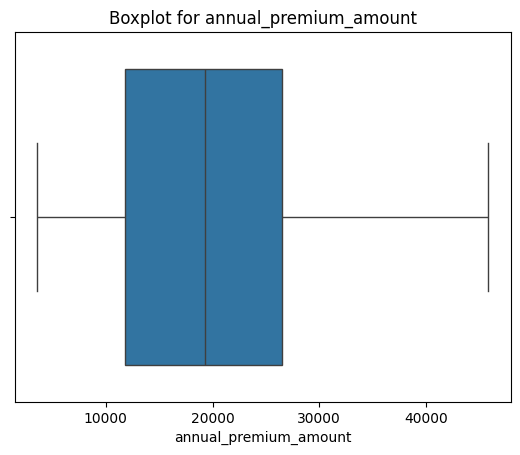

In [17]:
## finding outliers by boxplots for numeric columns
num_cols = ['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount']
for col in num_cols:
    plt.figure()
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot for {col}")
    plt.show()

In [18]:
## age column outliers handling
df[df['age']>100]['age'].unique()

array([ 128, 1178,  567,  456])

In [19]:
df1 = df[df['age'] <= 100]
df1['age'].describe()

count    9915.000000
mean       37.743621
std        13.975462
min        18.000000
25%        24.000000
50%        37.000000
75%        50.000000
max        72.000000
Name: age, dtype: float64

In [43]:
## income_lakhs outliers handling
income_threshold = df1['income_lakhs'].quantile(0.999)
income_threshold

np.float64(136.12000000048283)

In [44]:
df1[df1['income_lakhs'] > income_threshold].shape

(10, 15)

In [46]:
df2 = df1[df1['income_lakhs'] <= income_threshold]
df2['income_lakhs'].describe()

count    9905.000000
mean       22.676325
std        22.453983
min         1.000000
25%         6.000000
50%        16.000000
75%        31.000000
max       100.000000
Name: income_lakhs, dtype: float64

In [47]:
## number of dependents outliers handling
dep_threshold = df2['number_of_dependants'].quantile(0.99)
dep_threshold

np.float64(5.0)

In [48]:
df3 = df2[df2['number_of_dependants']<=dep_threshold]
df3['number_of_dependants'].describe()

count    9858.000000
mean        1.919963
std         1.503027
min         0.000000
25%         0.000000
50%         2.000000
75%         3.000000
max         5.000000
Name: number_of_dependants, dtype: float64

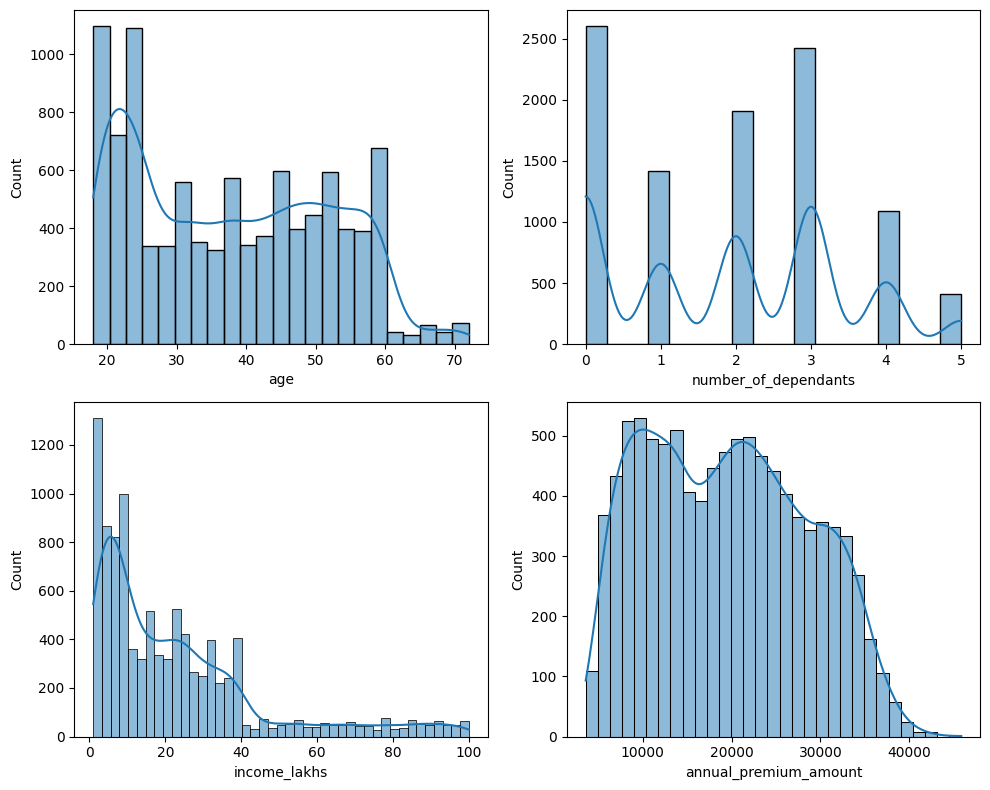

In [49]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,8))
for i, col in enumerate(num_cols):
    ax = axes[i//2, i%2]
    sns.histplot(df3[col], kde=True, ax=ax)
plt.tight_layout()
plt.show()

In [51]:
## Categorical columns
df3.head(3)

,age,gender,region,marital_status,physical_activity,stress_level,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,56,Female,Southeast,Unmarried,Medium,Medium,2,Normal,No Smoking,Self-Employed,25L - 40L,37,High blood pressure,Gold,27944
1,38,Female,Northeast,Married,Low,High,5,Overweight,Occasional,Freelancer,10L - 25L,10,No Disease,Silver,21108
2,18,Female,Southwest,Unmarried,Medium,High,0,Normal,No Smoking,Freelancer,<10L,9,No Disease,Bronze,8459


In [58]:
cat_cols = ['gender', 'region', 'marital_status', 'physical_activity', 'stress_level', 'bmi_category', 'smoking_status', 'employment_status', 'income_level', 'medical_history', 'insurance_plan']
for col in cat_cols:
    print(col,": \n", df3[col].unique())

gender : 
 ['Female' 'Male']
region : 
 ['Southeast' 'Northeast' 'Southwest' 'Northwest']
marital_status : 
 ['Unmarried' 'Married']
physical_activity : 
 ['Medium' 'Low' 'High']
stress_level : 
 ['Medium' 'High' 'Low']
bmi_category : 
 ['Normal' 'Overweight' 'Obesity' 'Underweight']
smoking_status : 
 ['No Smoking' 'Occasional' 'Regular']
employment_status : 
 ['Self-Employed' 'Freelancer' 'Salaried']
income_level : 
 ['25L - 40L' '10L - 25L' '<10L' '> 40L']
medical_history : 
 ['High blood pressure' 'No Disease' 'Thyroid'
 'High blood pressure & Heart disease' 'Diabetes & Thyroid' 'Diabetes'
 'Heart disease' 'Diabetes & High blood pressure'
 'Diabetes & Heart disease']
insurance_plan : 
 ['Gold' 'Silver' 'Bronze']


In [55]:
df3['gender'].value_counts()

gender
Female    5902
Male      3956
Name: count, dtype: int64

<Axes: xlabel='gender'>

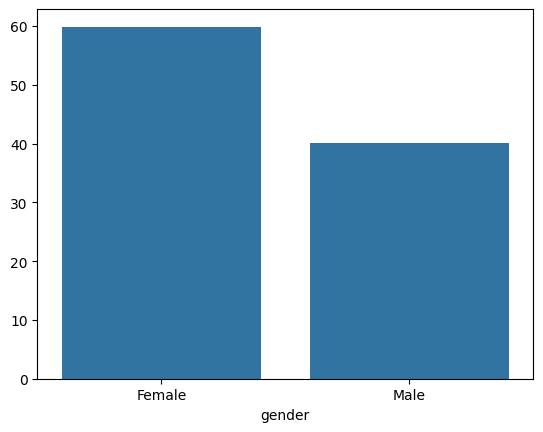

In [56]:
##  Percentage Distributions

pct_count_gender = df3['gender'].value_counts(normalize=True)*100
sns.barplot(x=pct_count_gender.index, y=pct_count_gender.values)

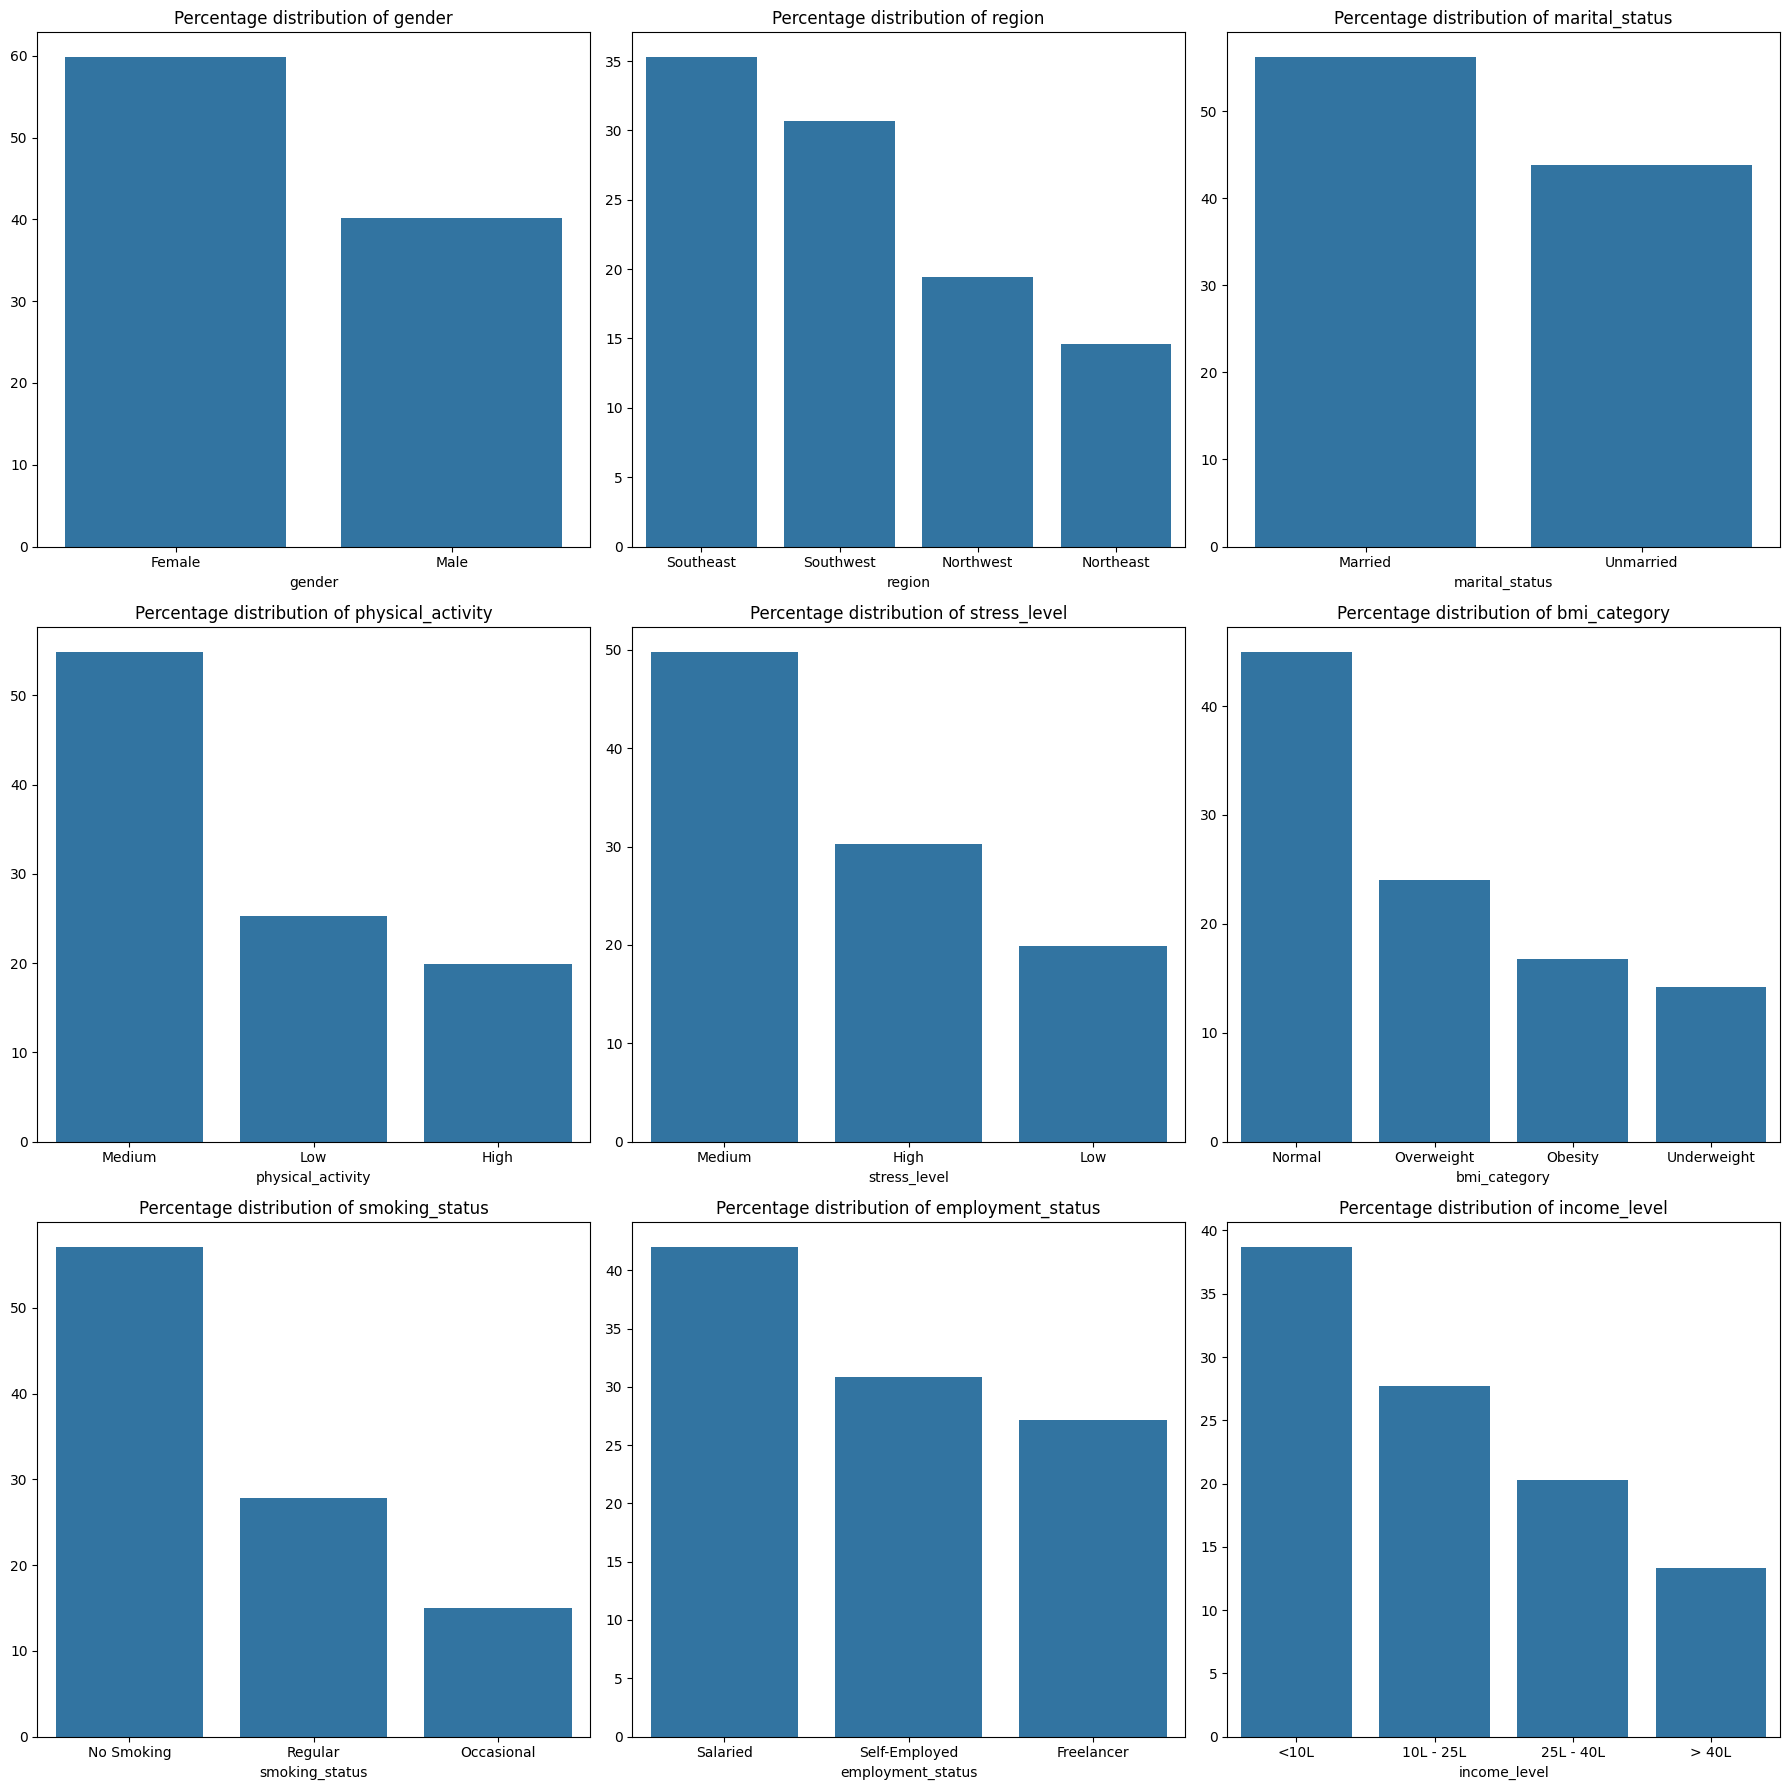

In [63]:
fig, axes = plt.subplots(3, 3, figsize=(18,18))
axes = axes.flatten()
for ax, col in zip(axes, cat_cols):
    cat_pct_count = df3[col].value_counts(normalize=True)*100
    sns.barplot(x=cat_pct_count.index, y=cat_pct_count.values, ax=ax)
    ax.set_title(f'Percentage distribution of {col}')
plt.tight_layout()
plt.show()

In [64]:
## cross tab of income_level and insurance_plan
crosstab = pd.crosstab(df3['income_level'], df3['insurance_plan'])
print(crosstab)

insurance_plan  Bronze  Gold  Silver
income_level                        
10L - 25L          822   909     998
25L - 40L          533   733     733
<10L              2266   184    1366
> 40L               55   788     471


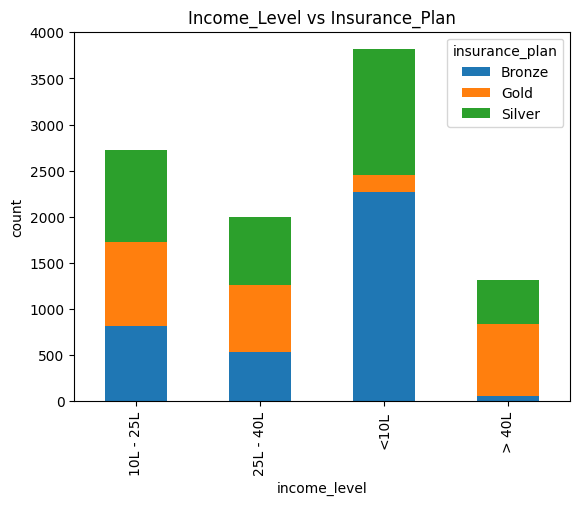

In [65]:
## stacked plot
crosstab.plot(kind='bar', stacked=True)
plt.title("Income_Level vs Insurance_Plan")
plt.ylabel('count')
plt.show()

## Feature Engineering

In [66]:
df3.head(3)

,age,gender,region,marital_status,physical_activity,stress_level,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,56,Female,Southeast,Unmarried,Medium,Medium,2,Normal,No Smoking,Self-Employed,25L - 40L,37,High blood pressure,Gold,27944
1,38,Female,Northeast,Married,Low,High,5,Overweight,Occasional,Freelancer,10L - 25L,10,No Disease,Silver,21108
2,18,Female,Southwest,Unmarried,Medium,High,0,Normal,No Smoking,Freelancer,<10L,9,No Disease,Bronze,8459


In [77]:
import warnings
warnings.filterwarnings('ignore')

In [80]:
## calculate risk score

# Define the risk scores for each condition
risk_scores = {
    "diabetes": 6,
    "heart disease": 8,
    "high blood pressure":6,
    "thyroid": 5,
    "no disease": 0,
    "none":0
}

df3[['dis1', 'dis2']] = df3['medical_history'].str.split(" & ", expand=True).apply(lambda x: x.str.lower())
df3['dis1'].fillna('none', inplace=True)
df3['dis2'].fillna('none', inplace=True)
df3['total_risk_score']=0


In [81]:
for dis in ['dis1', 'dis2']:
    df3['total_risk_score'] += df3[dis].map(risk_scores)

df3.head()

,age,gender,region,marital_status,physical_activity,stress_level,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,dis1,dis2,total_risk_score
0,56,Female,Southeast,Unmarried,Medium,Medium,2,Normal,No Smoking,Self-Employed,25L - 40L,37,High blood pressure,Gold,27944,high blood pressure,none,6
1,38,Female,Northeast,Married,Low,High,5,Overweight,Occasional,Freelancer,10L - 25L,10,No Disease,Silver,21108,no disease,none,0
2,18,Female,Southwest,Unmarried,Medium,High,0,Normal,No Smoking,Freelancer,<10L,9,No Disease,Bronze,8459,no disease,none,0
3,55,Male,Northeast,Married,High,Medium,3,Overweight,Occasional,Salaried,<10L,9,Thyroid,Silver,21685,thyroid,none,5
4,22,Male,Southeast,Unmarried,Medium,High,2,Normal,Regular,Self-Employed,10L - 25L,13,High blood pressure & Heart disease,Bronze,15984,high blood pressure,heart disease,14


In [82]:
## Calculate life-style risk score

df3['physical_activity'] = df3['physical_activity'].map({'High':0, 'Medium':1, 'Low':4})
df3['stress_level'] = df3['stress_level'].map({'High':4, 'Medium':1, 'Low':0})
df3['life_style_risk_score'] = df3['physical_activity'] + df3['stress_level']
df3.head()

,age,gender,region,marital_status,physical_activity,stress_level,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,dis1,dis2,total_risk_score,life_style_risk_score
0,56,Female,Southeast,Unmarried,1,1,2,Normal,No Smoking,Self-Employed,25L - 40L,37,High blood pressure,Gold,27944,high blood pressure,none,6,2
1,38,Female,Northeast,Married,4,4,5,Overweight,Occasional,Freelancer,10L - 25L,10,No Disease,Silver,21108,no disease,none,0,8
2,18,Female,Southwest,Unmarried,1,4,0,Normal,No Smoking,Freelancer,<10L,9,No Disease,Bronze,8459,no disease,none,0,5
3,55,Male,Northeast,Married,0,1,3,Overweight,Occasional,Salaried,<10L,9,Thyroid,Silver,21685,thyroid,none,5,1
4,22,Male,Southeast,Unmarried,1,4,2,Normal,Regular,Self-Employed,10L - 25L,13,High blood pressure & Heart disease,Bronze,15984,high blood pressure,heart disease,14,5


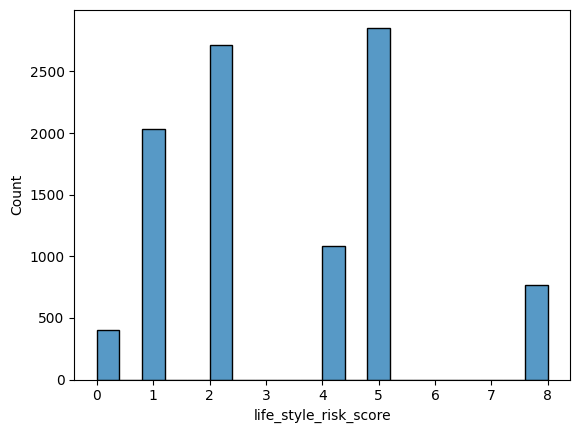

In [83]:
sns.histplot(df3['life_style_risk_score'], bins=20)
plt.show()

In [84]:
## Encode Categorical Ordinal values

df3['income_level'].unique()

array(['25L - 40L', '10L - 25L', '<10L', '> 40L'], dtype=object)

In [85]:
df3['income_level'] = df3['income_level'].map({'<10L' : 1, '10L - 25L':2, '25L - 40L':3, '> 40L':4})
df3.head()

,age,gender,region,marital_status,physical_activity,stress_level,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,dis1,dis2,total_risk_score,life_style_risk_score
0,56,Female,Southeast,Unmarried,1,1,2,Normal,No Smoking,Self-Employed,3,37,High blood pressure,Gold,27944,high blood pressure,none,6,2
1,38,Female,Northeast,Married,4,4,5,Overweight,Occasional,Freelancer,2,10,No Disease,Silver,21108,no disease,none,0,8
2,18,Female,Southwest,Unmarried,1,4,0,Normal,No Smoking,Freelancer,1,9,No Disease,Bronze,8459,no disease,none,0,5
3,55,Male,Northeast,Married,0,1,3,Overweight,Occasional,Salaried,1,9,Thyroid,Silver,21685,thyroid,none,5,1
4,22,Male,Southeast,Unmarried,1,4,2,Normal,Regular,Self-Employed,2,13,High blood pressure & Heart disease,Bronze,15984,high blood pressure,heart disease,14,5


In [86]:
df3['insurance_plan'].unique()

array(['Gold', 'Silver', 'Bronze'], dtype=object)

In [87]:
df3['insurance_plan'] = df3['insurance_plan'].map({'Gold':3, 'Silver':2, 'Bronze':1})
df3.head()

,age,gender,region,marital_status,physical_activity,stress_level,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,dis1,dis2,total_risk_score,life_style_risk_score
0,56,Female,Southeast,Unmarried,1,1,2,Normal,No Smoking,Self-Employed,3,37,High blood pressure,3,27944,high blood pressure,none,6,2
1,38,Female,Northeast,Married,4,4,5,Overweight,Occasional,Freelancer,2,10,No Disease,2,21108,no disease,none,0,8
2,18,Female,Southwest,Unmarried,1,4,0,Normal,No Smoking,Freelancer,1,9,No Disease,1,8459,no disease,none,0,5
3,55,Male,Northeast,Married,0,1,3,Overweight,Occasional,Salaried,1,9,Thyroid,2,21685,thyroid,none,5,1
4,22,Male,Southeast,Unmarried,1,4,2,Normal,Regular,Self-Employed,2,13,High blood pressure & Heart disease,1,15984,high blood pressure,heart disease,14,5


In [88]:
## Nominal columns - encoding

nominal_cols = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status']
df4 = pd.get_dummies(df3, columns=nominal_cols, drop_first=True, dtype=int)
df4.head()

,age,physical_activity,stress_level,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,dis1,...,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,56,1,1,2,3,37,High blood pressure,3,27944,high blood pressure,...,1,0,1,0,0,0,0,0,0,1
1,38,4,4,5,2,10,No Disease,2,21108,no disease,...,0,0,0,0,1,0,1,0,0,0
2,18,1,4,0,1,9,No Disease,1,8459,no disease,...,0,1,1,0,0,0,0,0,0,0
3,55,0,1,3,1,9,Thyroid,2,21685,thyroid,...,0,0,0,0,1,0,1,0,1,0
4,22,1,4,2,2,13,High blood pressure & Heart disease,1,15984,high blood pressure,...,1,0,1,0,0,0,0,1,0,1


In [90]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9858 entries, 0 to 9999
Data columns (total 25 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   age                              9858 non-null   int64 
 1   physical_activity                9858 non-null   int64 
 2   stress_level                     9858 non-null   int64 
 3   number_of_dependants             9858 non-null   int64 
 4   income_level                     9858 non-null   int64 
 5   income_lakhs                     9858 non-null   int64 
 6   medical_history                  9858 non-null   object
 7   insurance_plan                   9858 non-null   int64 
 8   annual_premium_amount            9858 non-null   int64 
 9   dis1                             9858 non-null   object
 10  dis2                             9858 non-null   object
 11  total_risk_score                 9858 non-null   int64 
 12  life_style_risk_score            9858 n

### Feature Selection

In [92]:
df5 = df4.drop(columns=['physical_activity', 'stress_level', 'medical_history', 'dis1', 'dis2'], axis=1)
df5.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,total_risk_score,life_style_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,56,2,3,37,3,27944,6,2,0,0,1,0,1,0,0,0,0,0,0,1
1,38,5,2,10,2,21108,0,8,0,0,0,0,0,0,1,0,1,0,0,0
2,18,0,1,9,1,8459,0,5,0,0,0,1,1,0,0,0,0,0,0,0
3,55,3,1,9,2,21685,5,1,1,0,0,0,0,0,1,0,1,0,1,0
4,22,2,2,13,1,15984,14,5,1,0,1,0,1,0,0,0,0,1,0,1


In [93]:
df5.columns

Index(['age', 'number_of_dependants', 'income_level', 'income_lakhs',
       'insurance_plan', 'annual_premium_amount', 'total_risk_score',
       'life_style_risk_score', 'gender_Male', 'region_Northwest',
       'region_Southeast', 'region_Southwest', 'marital_status_Unmarried',
       'bmi_category_Obesity', 'bmi_category_Overweight',
       'bmi_category_Underweight', 'smoking_status_Occasional',
       'smoking_status_Regular', 'employment_status_Salaried',
       'employment_status_Self-Employed'],
      dtype='object')

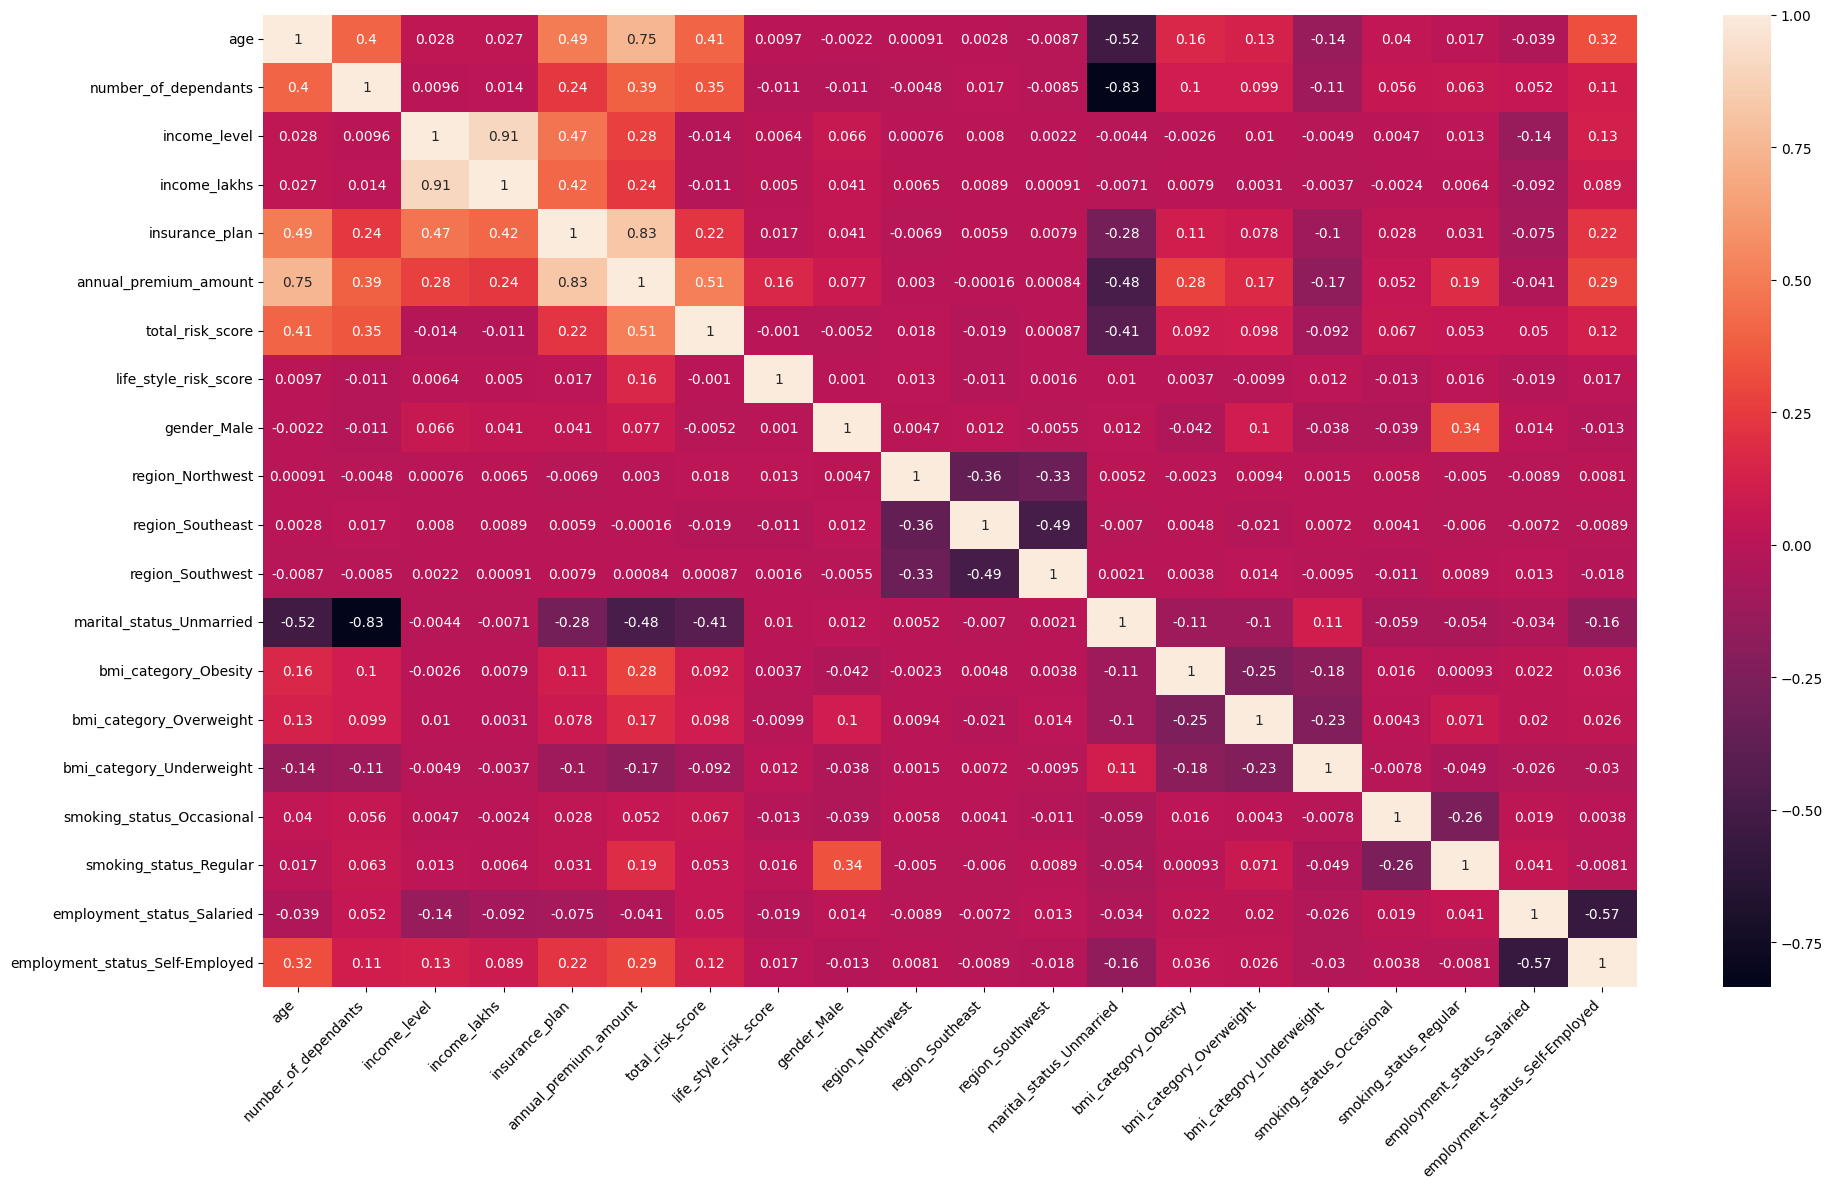

In [95]:
corrmat = df5.corr()
plt.figure(figsize=(20,12))
sns.heatmap(corrmat , annot=True)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [99]:
df5.head(3)

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,total_risk_score,life_style_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,56,2,3,37,3,27944,6,2,0,0,1,0,1,0,0,0,0,0,0,1
1,38,5,2,10,2,21108,0,8,0,0,0,0,0,0,1,0,1,0,0,0
2,18,0,1,9,1,8459,0,5,0,0,0,1,1,0,0,0,0,0,0,0


In [101]:
X = df5.drop('annual_premium_amount', axis=1)
y = df5['annual_premium_amount']

scaler = MinMaxScaler()
cols_to_scale = ['age', 'number_of_dependants', 'income_level', 'income_lakhs', 'total_risk_score', 'life_style_risk_score']
X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])
X.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,total_risk_score,life_style_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
count,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000
mean,0.366014,0.383993,0.360756,0.219027,1.892270,0.326537,0.408349,0.401298,0.194664,0.353013,0.306452,0.437716,0.167985,0.240414,0.141712,0.150030,0.278657,0.420065,0.308176
std,0.258820,0.300605,0.352198,0.226801,0.791529,0.279083,0.268302,0.490186,0.395962,0.477931,0.461043,0.496131,0.373872,0.427356,0.348773,0.357119,0.448361,0.493594,0.461763
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.111111,0.000000,0.000000,0.050505,1.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.351852,0.400000,0.333333,0.151515,2.000000,0.428571,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.592593,0.600000,0.666667,0.303030,3.000000,0.428571,0.625000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [104]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(df):
    vif_df = pd.DataFrame()
    vif_df['Column']=df.columns
    vif_df['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_df


In [105]:
calculate_vif(X)

,Column,VIF
0,age,5.855885
1,number_of_dependants,5.613017
2,income_level,12.609594
3,income_lakhs,10.947225
4,insurance_plan,11.435736
5,total_risk_score,3.013884
6,life_style_risk_score,3.131398
7,gender_Male,1.912232
8,region_Northwest,2.100487
9,region_Southeast,2.990943


In [106]:
##  Dropping income_level (high vif value)

X2 = X.drop(['income_level'], axis=1)
X2.head()

,age,number_of_dependants,income_lakhs,insurance_plan,total_risk_score,life_style_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.703704,0.4,0.363636,3,0.428571,0.250,0,0,1,0,1,0,0,0,0,0,0,1
1,0.370370,1.0,0.090909,2,0.000000,1.000,0,0,0,0,0,0,1,0,1,0,0,0
2,0.000000,0.0,0.080808,1,0.000000,0.625,0,0,0,1,1,0,0,0,0,0,0,0
3,0.685185,0.6,0.080808,2,0.357143,0.125,1,0,0,0,0,0,1,0,1,0,1,0
4,0.074074,0.4,0.121212,1,1.000000,0.625,1,0,1,0,1,0,0,0,0,1,0,1


### Model Training

In [108]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X2, y, test_size=0.3, random_state=42)
Xtrain.shape, ytrain.shape, Xtest.shape, ytest.shape

((6900, 18), (6900,), (2958, 18), (2958,))

### Linear Regression Model

In [110]:
lrmodel = LinearRegression()
lrmodel.fit(Xtrain, ytrain)

train_score = lrmodel.score(Xtrain, ytrain)
test_score = lrmodel.score(Xtest, ytest)
train_score, test_score

(0.9583441168970603, 0.957877163116046)

In [111]:
ypred_lr = lrmodel.predict(Xtest)
mse = mean_squared_error(ytest, ypred_lr)
rmse = np.sqrt(mse)
print(mse, rmse)

3271494.4534015628 1808.727302110952


In [113]:
np.set_printoptions(suppress=True, precision=6)

lrmodel.coef_

array([10816.978546,  -636.570995,  -766.012668,  6629.86355 ,
        6487.236252,  4722.854268,    84.78725 ,    76.516451,
         113.662324,     0.625549,  -769.22107 ,  4121.871374,
        2068.552203,   364.012454,  1190.632535,  3087.600539,
          44.86986 ,   364.430996])

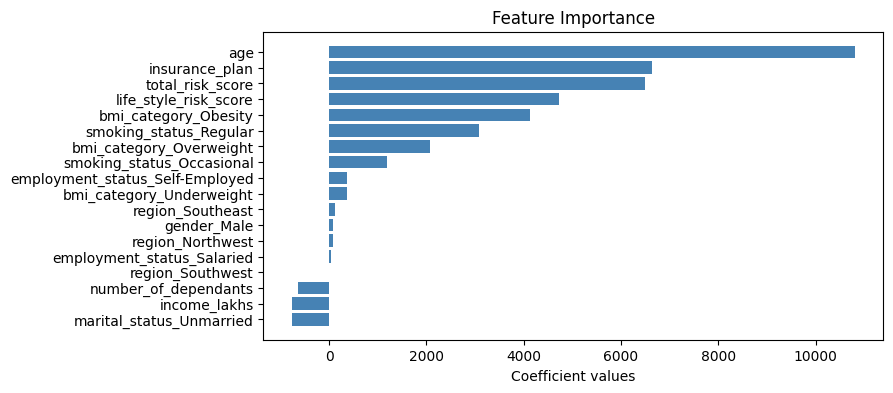

In [142]:
feature_importance = lrmodel.coef_

coef_df = pd.DataFrame(feature_importance, index=Xtrain.columns, columns=['Coefficients'])
coef_df = coef_df.sort_values(by='Coefficients', ascending=True)

plt.figure(figsize=(8,4))
plt.barh(coef_df.index, coef_df.Coefficients, color='steelblue')
plt.title('Feature Importance')
plt.xlabel("Coefficient values")
plt.show()

### XGBoost

In [118]:
from xgboost import XGBRegressor

xgbmodel = XGBRegressor(n_estimators=50, max_depth=3)
xgbmodel.fit(Xtrain, ytrain)
xgbmodel.score(Xtest, ytest) , xgbmodel.score(Xtrain, ytrain)

(0.9942646622657776, 0.994688093662262)

In [119]:
ypred = xgbmodel.predict(Xtest)

mse = mean_squared_error(ytest, ypred)
rmse = np.sqrt(mse)
mse, rmse

(445439.09375, np.float64(667.4122367397829))

In [120]:
xgbmodel = XGBRegressor()

params = {
    'n_estimators' : [20, 40, 50 , 60, 70, 90, 100],
    'learning_rate' : [0.01, 0.05, 0.1, 0.2],
    'max_depth' : [3, 4, 5, 6]
}

randomsearch = RandomizedSearchCV(xgbmodel, params, n_iter=10, cv=3, scoring='r2', random_state=22, n_jobs=-1)
randomsearch.fit(Xtrain, ytrain)
randomsearch.best_score_

np.float64(0.9936721324920654)

In [121]:
randomsearch.best_params_

{'n_estimators': 40, 'max_depth': 4, 'learning_rate': 0.2}

In [122]:
bestmodel = randomsearch.best_estimator_

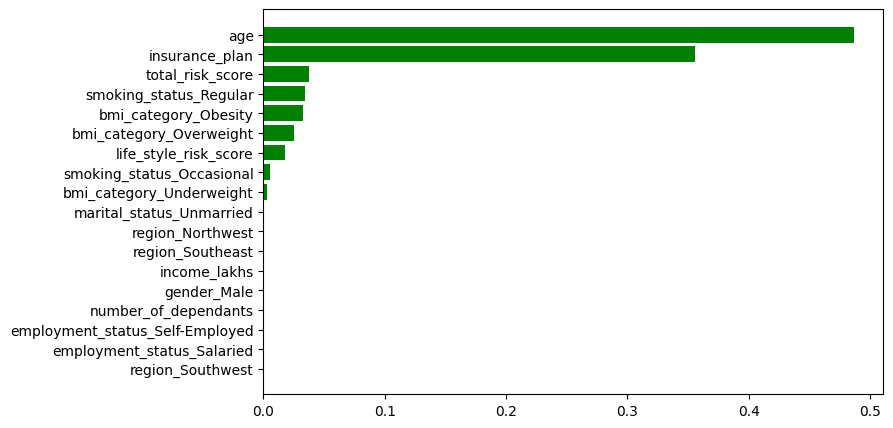

In [124]:
feature_importances = bestmodel.feature_importances_

coefdf = pd.DataFrame(feature_importances, index=Xtrain.columns, columns=['Coefficients'])
coefdf = coefdf.sort_values(by='Coefficients', ascending=True)

plt.figure(figsize=(8,5))
plt.barh(coefdf.index, coefdf['Coefficients'], color='green')
plt.show()

In [126]:
## Calculate percentage of errors

ypred = bestmodel.predict(Xtest)
err = abs(ypred - ytest)
errpct = (err * 100) / ytest

errpctdf = pd.DataFrame({
    'actual' : ytest,
    'predicted' : ypred,
    'err' : err,
    'err_pct' : errpct
})
errpctdf.head()

,actual,predicted,err,err_pct
8496,30733,30651.308594,81.691406,0.265810
507,32997,32581.146484,415.853516,1.260277
5147,15251,16397.050781,1146.050781,7.514594
887,6936,7696.197754,760.197754,10.960175
8848,10909,11747.073242,838.073242,7.682402


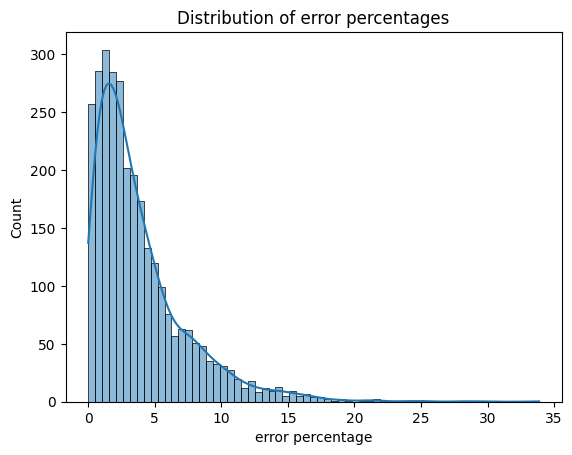

In [143]:
## Distribution of error percentage values

sns.histplot(errpctdf['err_pct'],  kde=True)
plt.xlabel("error percentage")
plt.title("Distribution of error percentages")
plt.show()

In [130]:
extreme_error_threshold_pct = 10

extreme_errors_df = errpctdf[errpctdf['err_pct']>10]
extreme_errors_df.head()

,actual,predicted,err,err_pct
887,6936,7696.197754,760.197754,10.960175
8963,14296,15897.700195,1601.700195,11.203835
1918,7431,8484.283203,1053.283203,14.174178
7772,7225,6116.917969,1108.082031,15.336776
6559,6565,7314.939453,749.939453,11.423297


In [131]:
extreme_errors_df.shape

(194, 4)

In [132]:
ytest.shape

(2958,)

In [133]:
extreme_errors_pct = (extreme_errors_df.shape[0] *100) / Xtest.shape[0]
extreme_errors_pct

6.558485463150777

## Export Model

In [136]:
from joblib import dump

dump(bestmodel, "artifacts/prem_pred_ex_model.joblib")
scaler_with_cols = {
    'scaler' : scaler,
    'cols_to_scale' : cols_to_scale
}
dump(scaler_with_cols, "artifacts/prem_pred_ex_scaler.joblib")


['artifacts/prem_pred_ex_scaler.joblib']

In [141]:
xtraincols = ['age', 'number_of_dependants', 'income_lakhs', 'insurance_plan','total_risk_score', 'life_style_risk_score', 'gender_Male',
              'region_Northwest', 'region_Southeast', 'region_Southwest', 'marital_status_Unmarried', 'bmi_category_Obesity','bmi_category_Overweight', 
            'bmi_category_Underweight', 'smoking_status_Occasional', 'smoking_status_Regular', 'employment_status_Salaried', 'employment_status_Self-Employed']
expected_cols = {
    'cols' : xtraincols
}
dump(expected_cols, "artifacts/prem_pred_ex_cols.joblib")

['artifacts/prem_pred_ex_cols.joblib']